In [9]:
import time
from zipfile import ZipFile
import pandas as pd
import numpy as np
from progressbar import ProgressBar, Bar, Percentage
import os
import cv2
from PIL import Image

from matplotlib import pyplot as plt

In [2]:
with ZipFile('xray_images.zip', 'r') as zip_ref:
    zip_ref.extractall('xray_images')

In [3]:
def encode_images():
    filenames = []
    X = []

    directories = ['xray_images/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/', 
                  'xray_images/Montgomery/MontgomerySet/CXR_png/']
    n_files = 0

    for directory in directories:
        n_files += len(os.listdir(directory))

    counter = 0

    bar = ProgressBar(maxval=n_files+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
    bar.start()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                filenames.append(filename)
                X.append(cv2.imread(directory + filename))
                counter += 1
                bar.update(counter)

    bar.finish()

    y = [int(filename[-5]) for filename in filenames]
    
    return X, y

In [4]:
X, y = encode_images()

[========================================================================] 100%


In [5]:
def plot_dimensions(X):
    widths = [i.shape[0] for i in X]
    heights = [i.shape[1] for i in X]
    depths = [i.shape[2] for i in X]
    
    dimensions = [widths, heights, depths]
    
    fig = plt.figure(figsize=(14, 4))
    for i in range(len(dimensions)):
        print((min(dimensions[i]), max(dimensions[i])), min(dimensions[i]) == max(dimensions[i]))
        ax = fig.add_subplot(1, 3, i+1)
        ax.hist(dimensions[i], bins=20)
    
    plt.show()
    

(948, 4892) False
(1130, 4892) False
(3, 3) True


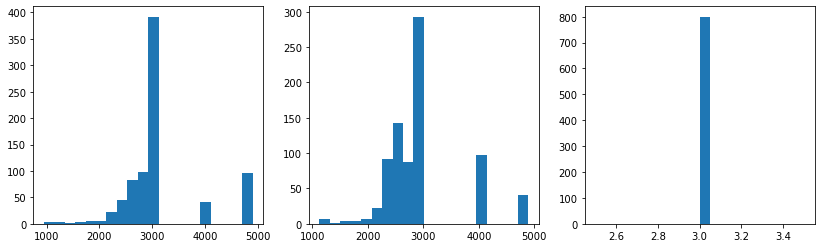

In [6]:
plot_dimensions(X)

In [8]:
widths = [i.shape[0] for i in X]
heights = [i.shape[1] for i in X]
min(min(widths), min(heights))

948

In [16]:
def resize_encode_images():
    filenames = []
    X = []

    directories = ['xray_images/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/', 
                  'xray_images/Montgomery/MontgomerySet/CXR_png/']
    n_files = 0

    for directory in directories:
        n_files += len(os.listdir(directory))

    counter = 0

    bar = ProgressBar(maxval=n_files+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
    bar.start()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                filenames.append(filename)
                img = Image.open(directory + filename)
                img = img.resize((1024, 1024))
                img.save(directory + filename)
                X.append(cv2.imread(directory + filename))
                counter += 1
                bar.update(counter)

    bar.finish()

    y = [int(filename[-5]) for filename in filenames]
    
    return X, y

In [17]:
X, y = resize_encode_images()

[========================================================================] 100%


(1024, 1024) True
(1024, 1024) True
(3, 3) True


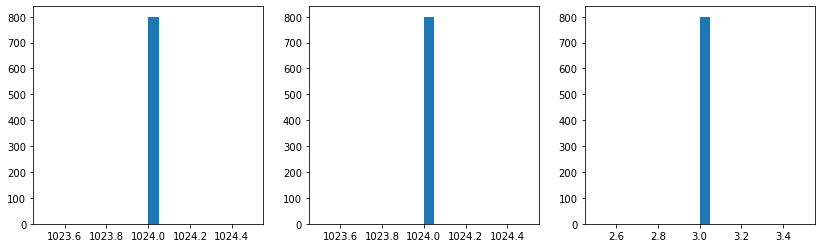

In [18]:
plot_dimensions(X)